In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

## Utils

In [2]:
def read_data(folder, threads, sleeping_threshold_us):
    master_df = None

    for i in range(1, threads + 1):
        filename = folder + '/master-' + str(i) + '-threads.csv'
        new_data = pd.read_csv(filename)
        new_data['threads'] = i
        new_data['branch'] = 'master'
        master_df = pd.concat([master_df, new_data], ignore_index = True)

    new_algorithm_df = None

    for i in range(1, threads + 1):
        filename = folder + '/new-algorithm-' + str(i) + '-threads-' + str(sleeping_threshold_us) + 'us.csv'
        new_data = pd.read_csv(filename)
        new_data['threads'] = i
        new_data['branch'] = 'new-algorithm'
        new_algorithm_df = pd.concat([new_algorithm_df, new_data], ignore_index = True)
    
    return pd.concat([master_df, new_algorithm_df], ignore_index = True)


def calculate_speedups(dataframe):
    single_core_df = dataframe[dataframe['threads'] == 1]
    multi_core_df = dataframe[dataframe['threads'] > 1]
    speedups = {'name': [], 'speedup': [], 'cores': [], 'branch': []}

    for algorithm in set(dataframe['name']):
        single_core_mean = 18446744073709551615

        for branch in set(dataframe['branch']):
            algorithm_single_core_branch = single_core_df[(single_core_df['name'] == algorithm) &
                                                          (single_core_df['branch'] == branch)]
            
            branch_mean = algorithm_single_core_branch['wall_clock_time_us'].mean()
            single_core_mean = min(single_core_mean, branch_mean)
            
        for branch in set(dataframe['branch']):
            for thread in set(multi_core_df['threads']):
                algorithm_multi_core_df = multi_core_df[(multi_core_df['name'] == algorithm) &
                                                        (multi_core_df['threads'] == thread) &
                                                        (multi_core_df['branch'] == branch)]

                multi_core_mean = algorithm_multi_core_df['wall_clock_time_us'].mean()
                speedup = single_core_mean / multi_core_mean

                speedups['name'].append(algorithm)
                speedups['speedup'].append(speedup)
                speedups['cores'].append(thread)
                speedups['branch'].append(branch)
    
    return speedups


def plot_speedup(df, title):
    fig, axs = plt.subplots(1, len(set(df['name'])), figsize=(15, 5))
    fig.suptitle(title)
    
    for i, algorithm in enumerate(set(df['name'])):
        df_to_plot = df[df['name'] == algorithm]
        sns.lineplot(x='cores', y='speedup', hue='branch', data=df_to_plot, ax=axs[i]);

        axs[i].set_title(algorithm)
        axs[i].set_ylabel('speedup')
        axs[i].set_xlabel('threads')

        ymax = max(df_to_plot['speedup'])
        xmax = df_to_plot[df_to_plot['speedup'] == ymax]['cores'].iloc[0]
        axs[i].annotate('threads = {}'.format(xmax), \
                    xy=(xmax, ymax), xycoords='data', \
                    xytext=(xmax, ymax), textcoords='data', \
                    arrowprops=dict(facecolor='blue', shrink=0.05))


## Speedup curves with SLEEPING_THRESHOLD set to 10 us

,name,machine_id,threads,cpu_time_us,wall_clock_time_us,package_energy,core_energy,branch
6688,Life - sequential generation,dahu-10.grenoble.grid5000.fr,48,626471,99899,7612895,720432,new-algorithm
2031,NBody sequential,dahu-10.grenoble.grid5000.fr,34,36303,36330,1807429,148563,master
6806,Life - sequential generation,dahu-10.grenoble.grid5000.fr,50,667494,100060,6487532,722695,new-algorithm
5124,Life - sequential generation,dahu-10.grenoble.grid5000.fr,22,215360,88986,5241198,526044,new-algorithm
3176,Life - sequential generation,dahu-10.grenoble.grid5000.fr,53,76486,76567,4567432,540381,master
2444,Life - sequential generation,dahu-10.grenoble.grid5000.fr,41,78388,78461,4804553,565718,master
1964,Life - sequential generation,dahu-10.grenoble.grid5000.fr,33,76018,76184,4606312,559016,master
3729,NBody sequential,dahu-10.grenoble.grid5000.fr,63,36355,36320,2348565,256903,master
884,Life - sequential generation,dahu-10.grenoble.grid5000.fr,15,75662,75688,3646231,297707,master
187,NBody sequential,dahu-10.grenoble.grid5000.fr,4,33724,33851,1928279,239322,master


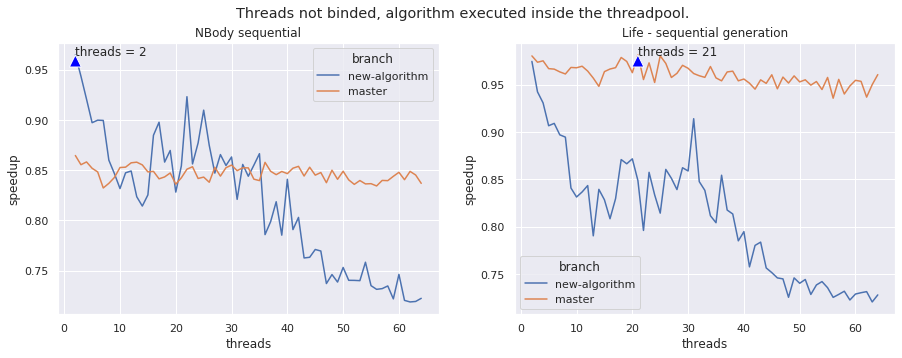

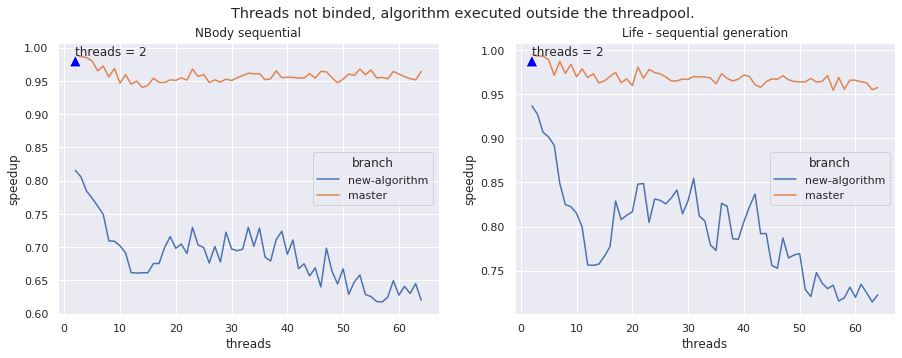

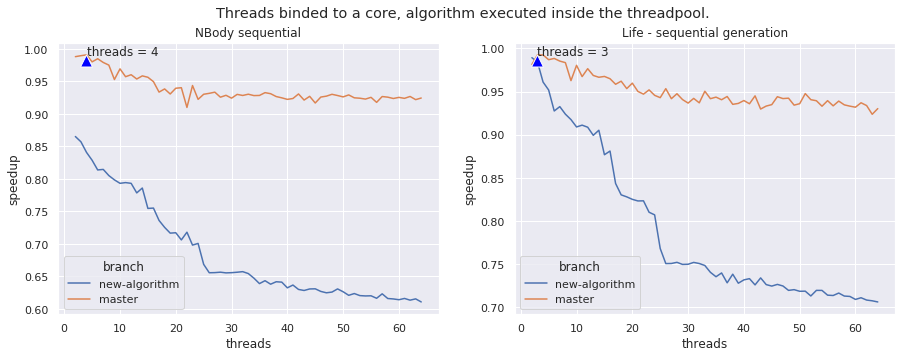

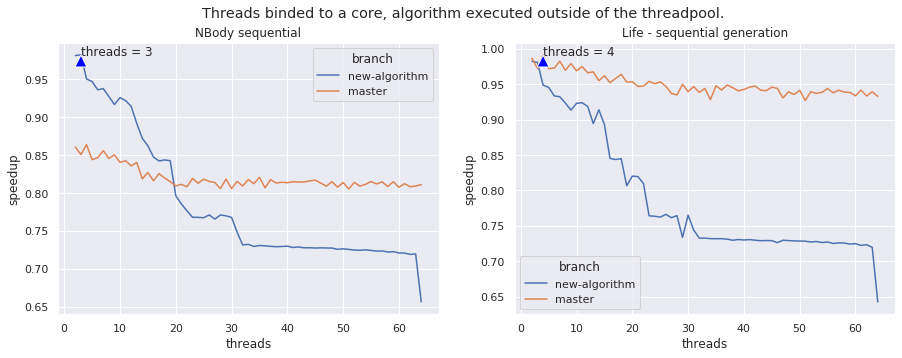

In [3]:
experiments = ['seq-debug', 'seq-debug-outside-tp', 'seq-debug-bind', 'seq-debug-bind-outside-tp']

descriptions = {
    'seq-debug': 'Threads not binded, algorithm executed inside the threadpool.',
    'seq-debug-outside-tp': 'Threads not binded, algorithm executed outside the threadpool.',
    'seq-debug-bind': 'Threads binded to a core, algorithm executed inside the threadpool.',
    'seq-debug-bind-outside-tp': 'Threads binded to a core, algorithm executed outside of the threadpool.'
}

for experiment in experiments:
    experiment_df = read_data(experiment, 64, 10)
    speedups = calculate_speedups(experiment_df)
    df = pd.DataFrame(data=speedups)
    plot_speedup(df, descriptions[experiment])
    
experiment_df.sample(10)

## Speedup curves varying the sleeping threshold

In [11]:
sleep_durations = [1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 20000, 40000, 60000, 80000, 100000]
df = None

for thread in range(1, 33):
    for st in sleep_durations:
        filename = 'ff-st/speedup-{}-threads-{}-us.csv'.format(thread, st)
        df_exp = pd.read_csv(filename)
        df_exp['branch'] = str(st) + 'us'
        df = pd.concat([df, df_exp], ignore_index = True)

df.sample(10)

,name,machine_id,threads,cpu_time_us,wall_clock_time_us,package_energy,core_energy,branch
20959,Life - sequential generation,dahu-27.grenoble.grid5000.fr,25,150337,150145,12408415,1249382,100000us
15550,Life - sequential generation,dahu-27.grenoble.grid5000.fr,19,152783,149647,12718962,1245542,5000us
17696,NBody sequential,dahu-27.grenoble.grid5000.fr,22,170640,64140,5460985,540289,1us
23020,NBody sequential,dahu-27.grenoble.grid5000.fr,28,79622,64221,5370226,537214,500us
475,NBody sequential,dahu-27.grenoble.grid5000.fr,1,64074,64096,5260851,535790,5000us
17982,NBody sequential,dahu-27.grenoble.grid5000.fr,22,74978,64394,5331834,537719,500us
1799,NBody sequential,dahu-27.grenoble.grid5000.fr,3,71345,64095,5285326,537275,5us
5779,Life - sequential generation,dahu-27.grenoble.grid5000.fr,7,149423,149393,12280364,1247455,80000us
18512,NBody sequential,dahu-27.grenoble.grid5000.fr,23,179469,64213,5562852,540824,1us
26277,NBody sequential,dahu-27.grenoble.grid5000.fr,32,163622,64113,5522447,537703,50us


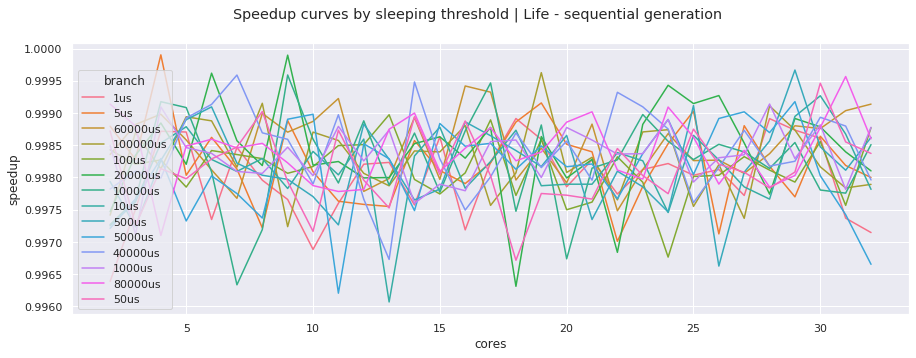

In [12]:
speedups = calculate_speedups(df)
speedups_df = pd.DataFrame(data=speedups)
speedups_df = speedups_df[speedups_df['name'] == 'Life - sequential generation']

fig, ax = plt.subplots(1, figsize=(15, 5))
fig.suptitle('Speedup curves by sleeping threshold | {}'.format(speedups_df['name'].values[0]))

sns.lineplot(x='cores', y='speedup', hue='branch', data=speedups_df, ax=ax);
